213093.76710402238
139929.51330602833
[139929.51330603 190509.83928159 209357.09936669 212052.52924565
 212590.83101069 212809.68737541 212956.32610823 213019.18647767
 213093.76710402 213162.4126473  213219.70175171 213227.70831975
 213225.75038731 213267.23696785 213286.77747043 213301.69356999
 213325.16626601 213338.98134194 213340.91731711 213349.25393585]
(2000, 2)


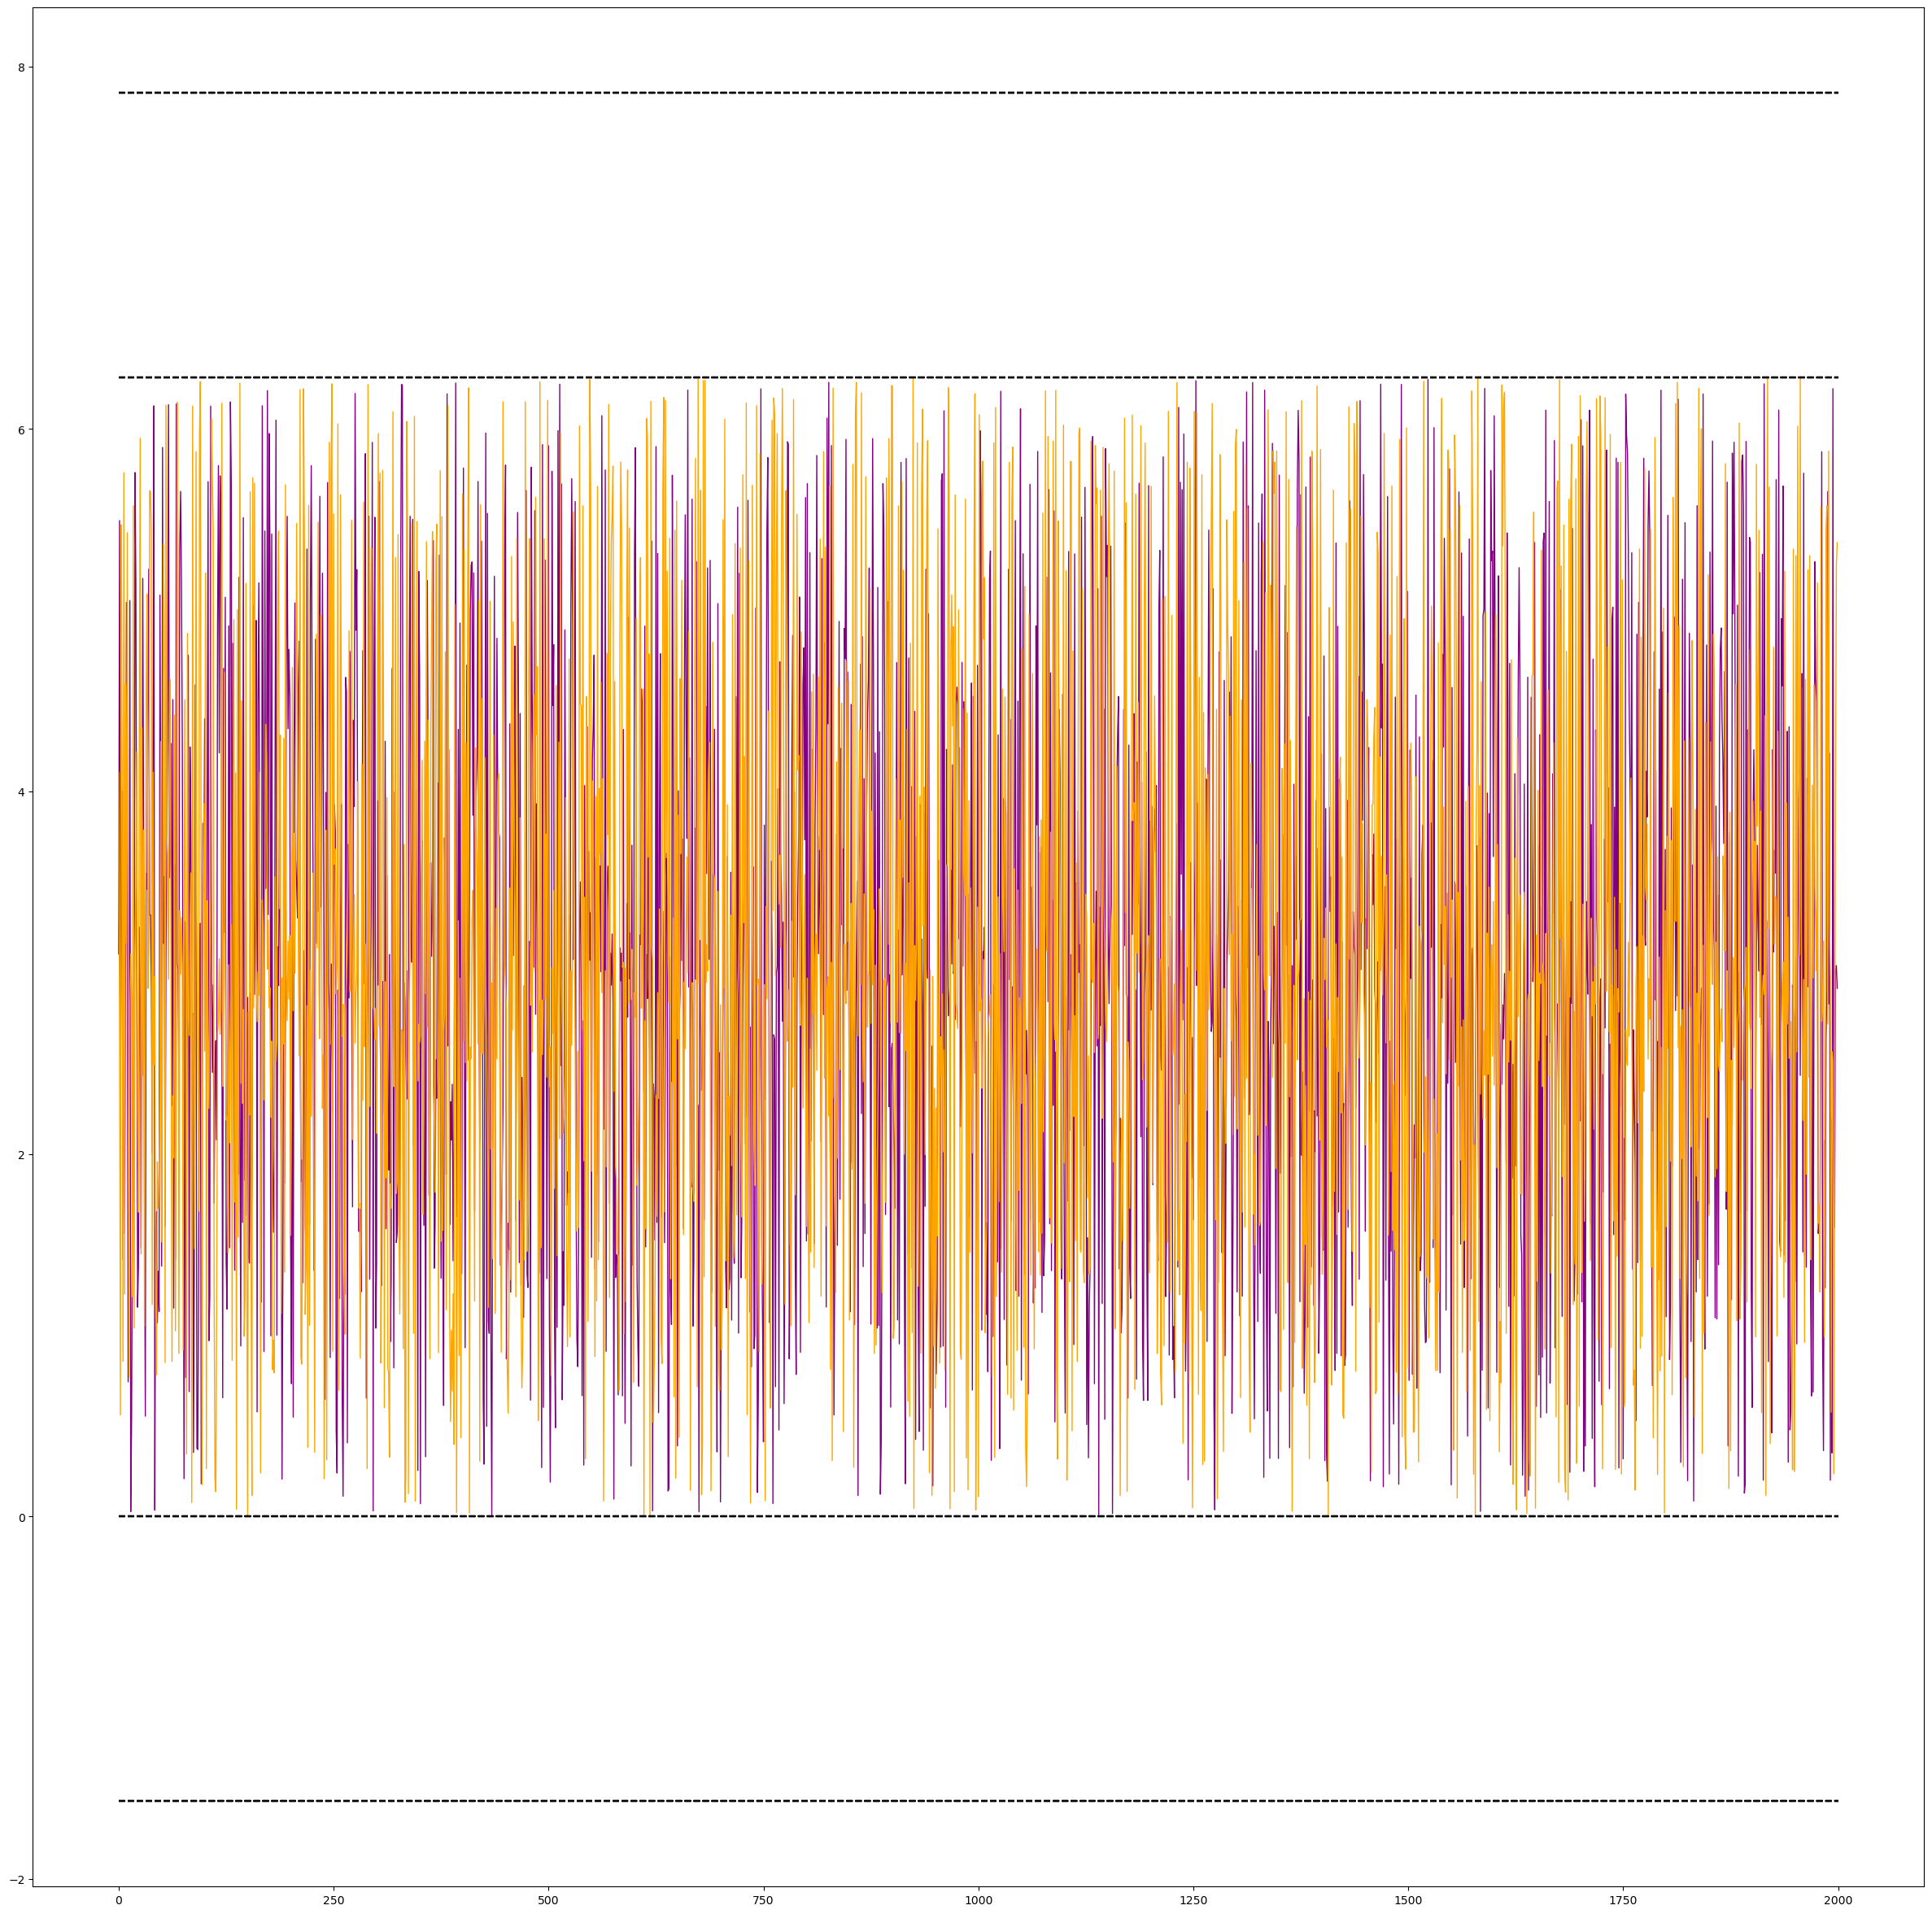

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.ndimage
import sys
from scipy.optimize import minimize
from scipy.special import gammaln
import time
import concurrent.futures
import pickle
import gzip
import plotly
import os



folder_name = 'results/24.1.24/'
file_name = 'best_estDir_correctangle' #CHANGED
file_path = os.path.join(folder_name, file_name)
with gzip.open('%s.pkl.gz'%file_path, 'rb') as f:
    data = np.load(f, allow_pickle=True)

estDir, estDirStd, totnegLogL, params, llvals = data['estDir'], data['estDirStd'],  data['totnegLogL'],data['params'],data['llvals']
print(llvals)


plt.figure(figsize=(30,30))
plt.clf()
estDir = estDir%(2.*np.pi)
#DDp = (DD+2.*DDstd)
#DDm = (DD-2.*DDstd)
for i in range(10):
    plt.figure
    si = 2000*i
    ei = 2000*(i+1)
    plt.plot(estDir[si:ei,0], '-', color='purple', lw=1)
    plt.plot(estDir[si:ei,1], '-', color='orange', lw=1)
    plt.plot([0,2000], [0, 0], '--', color='black')
    plt.plot([0,2000], [-np.pi/2., -np.pi/2.], '--', color='black')
    plt.plot([0,2000], [2.*np.pi, 2.*np.pi], '--', color='black')
    plt.plot([0,2000], [2.*np.pi+np.pi/2., 2.*np.pi+np.pi/2.], '--', color='black')
print(estDir.shape)

In [29]:
name = 'justonecircle' #CHANGED
with gzip.open('justonecircle.pkl.gz', 'rb') as f:
    data = pickle.load(f)

# Extract data
hd_sim = data['circvalues']
allspikes = np.array(data['S']) #neuron data
hd_sim_test = data['circvalues_test']
allspikes_test = np.array(data['S_test']) #neuron data
print(allspikes.shape, hd_sim.shape, allspikes_test.shape, hd_sim_test.shape)
#print(DD.shape)
print(totnegLogL)

(25, 2000) (2000,) (25, 500) (500,)
73727.14118395245


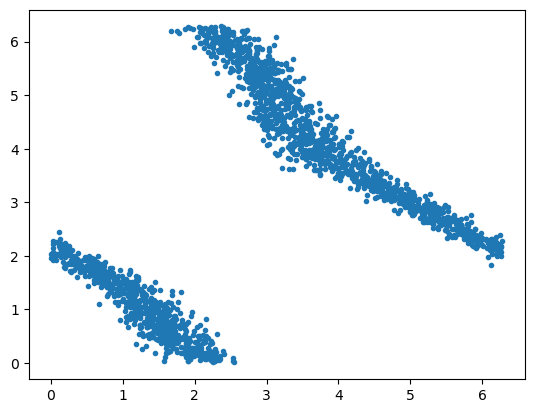

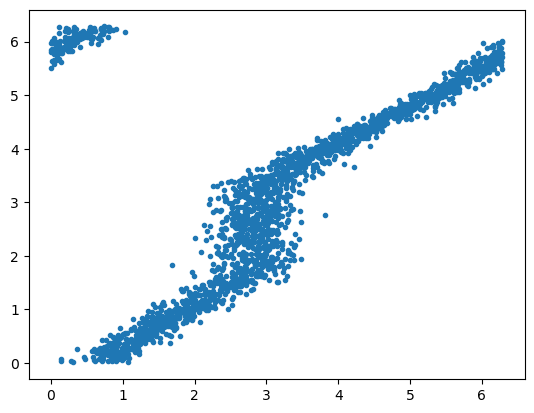

In [17]:
plt.figure()
plt.plot(estDir[:,0] , hd_sim, '.')
#plt.plot(np.transpose(hd_sim)[1:10])

plt.figure()
plt.plot(estDir[:,1], hd_sim, '.')

In [61]:
def rotateanglestoalign(DDtry, correctangles):
    def disttotrue(a):
        dd = np.abs(DDtry - hd_sim + a[0])
        dd = np.minimum(dd, 2.*np.pi - dd)
        return np.sum(dd**2)

    # first try without flipping
    result = minimize(disttotrue, [np.pi], method='L-BFGS-B')
    val = result.fun
    offset = result.x[0]

    ## now try flipped
    DDorig = DDtry + 0.
    DDtry = 2.*np.pi - DDtry
    result = minimize(disttotrue, [np.pi], method='L-BFGS-B')
    if result.fun < val:
        return (DDtry + result.x[0]) % (2.*np.pi)
    else:
        return (DDorig + offset) % (2.*np.pi)

def getH(a, D): ## H is the "lambda" for the Poisson random variable
    tc_preftheta = a[0] % (2.*np.pi) # Angles
    tc_prefphi = a[1] % (2.*np.pi)
    tc_beta = a[2] # This is a weight of the gaussian bumb
    tc_h = a[3] # This is background fire rate
    tc_sigma = np.pi/2 ### note, HYPERPARAMETER, also the width of the bumb or variance of the normal dist. 
    if(len(a)>4):
        tc_sigma = a[4]
    distsqrds = ToroidalDist([tc_preftheta, tc_prefphi], D)
    return( tc_h + tc_beta * np.exp(-distsqrds / (2*tc_sigma**2)) )

def logLtc(a, Sj, D): ## negative log likelihood of the Poisson (except for log factorial term)
        H = getH(a, D)
        #print("sizes of return values from LogLtc: Sj, H =", Sj.shape, H.shape )
        return (-np.sum(Sj*H - np.exp(H)))

def ToroidalDist(angles, D):
    D = np.array(D)
    theta = angles[0]
    phi = angles[1]
    #print("tehta, phi, D: ", theta, phi, D)
    
    dx = np.zeros_like(D[:,0])
    dy = np.zeros_like(D[:,0])
    
    for i in range(len(D)):
        dx[i] = abs(D[i, 0] - theta)
        dy[i] = abs(D[i, 1] - phi)
        dx[i] = np.minimum(dx[i], 2 * np.pi - dx[i])
        dy[i] = np.minimum(dy[i], 2 * np.pi - dy[i])
    #print(dx,dy)
    return np.sqrt(dx**2 + dy**2)



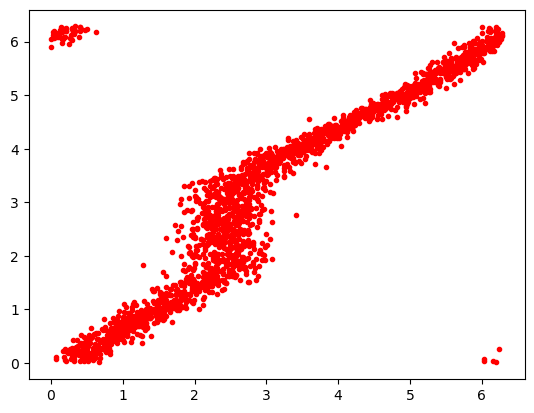

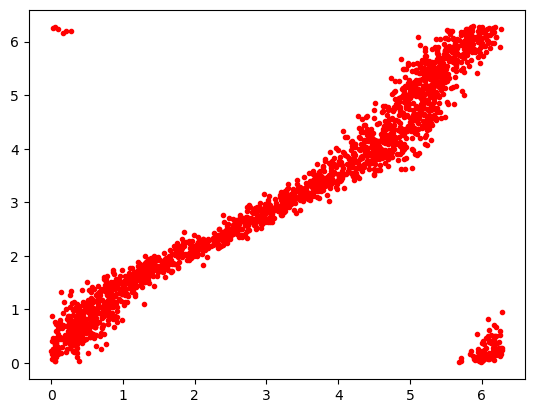

In [62]:
estDir[:,0] = rotateanglestoalign(estDir[:,0], hd_sim)
estDir[:,1] = rotateanglestoalign(estDir[:,1], hd_sim)

plt.figure()
plt.plot(estDir[:,1], hd_sim, '.', color = 'red',label = "estimated final dir")

plt.figure()
plt.plot(estDir[:,0], hd_sim, '.', color= 'red' )

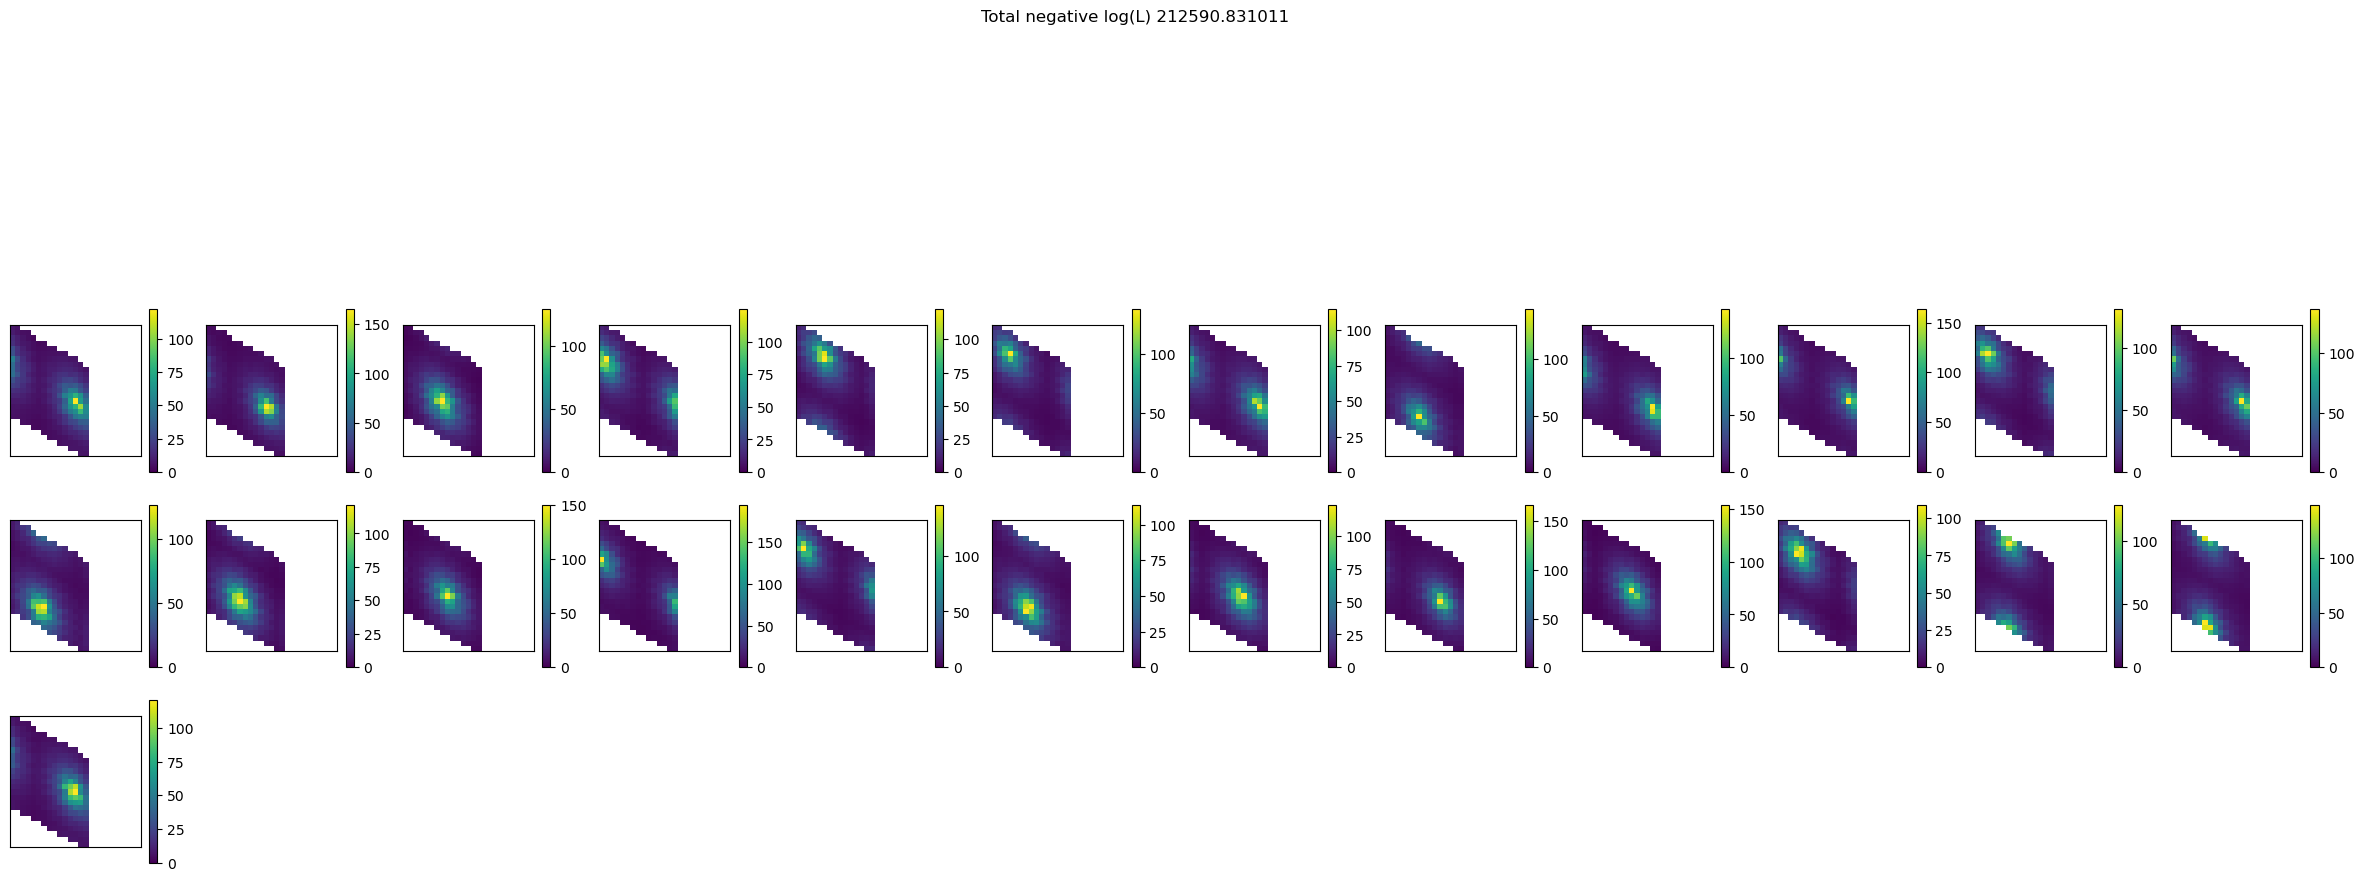

In [63]:
binsize= np.pi/32
N = 2000
if(True):
    fig = plt.figure(2, figsize=(30,30))
    plt.clf()
    size=25
    angs = np.linspace(0, 2.*np.pi, size)
    tangs = np.zeros((size*size, 2))
    for j in range(size):
      for k in range(size):
        tangs[j*size+k, 0] = angs[j]
        tangs[j*size+k, 1] = angs[k]
    xx = tangs[:,0] + 0.5*tangs[:,1]
    yy = np.sqrt(3)*tangs[:,1]/2.# max is 3*np.pi
    for j in range(np.min([N,size])):
      fr = plt.subplot(12,12,j+1)
      ratemapvals = np.exp(getH(params[j,:],tangs))/binsize
      twistrm = np.zeros((size,size))
      twistrm[:] = np.nan
      for k in range(len(xx)):
        ki = np.min([size-1, int(size*xx[k]/(3.*np.pi))])
        kj = np.min([size-1, int(size*yy[k]/(3.*np.pi))])
        twistrm[ki,kj] = ratemapvals[k]
      plt.imshow(twistrm, vmin=0.)
      plt.colorbar()
      fr.axes.get_xaxis().set_visible(False)
      fr.axes.get_yaxis().set_visible(False)
    fig.suptitle('Total negative log(L) %f'%(llvals[4]))


In [65]:
import plotly.graph_objects as go
import numpy as np

# Create grid values for theta and phi
theta = np.linspace(0, 2 * np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 100)
theta, phi = np.meshgrid(theta, phi)

# Parametric equations for the torus with R = r = 1
x = (1 + np.cos(theta)) * np.cos(phi)
y = (1 + np.cos(theta)) * np.sin(phi)
z = np.sin(theta)

# Create the figure for the torus
fig = go.Figure(data=[
    go.Surface(
        x=x, y=y, z=z,
        showscale=False,
        colorscale=['grey','grey'],  # Sets the color to grey
        opacity=0.5  # Makes the torus translucent
    )
])

# Add points to the plot (replace these with your specific points)
# Example points:

points_theta_sim = np.array(hd_sim)
points_phi_sim = np.array(hd_sim)

points_theta_res = np.array(estDir[:,0])
points_phi_res = np.array(estDir[:,1])


points_x = (1 + np.cos(points_theta_sim)) * np.cos(points_phi_sim)
points_y = (1 + np.cos(points_theta_sim)) * np.sin(points_phi_sim)
points_z = np.sin(points_theta_sim)


points_x2 = (1 + np.cos(points_theta_res)) * np.cos(points_phi_res)
points_y2 = (1 + np.cos(points_theta_res)) * np.sin(points_phi_res)
points_z2 = np.sin(points_theta_res)

# Add the points to the figure
fig.add_trace(go.Scatter3d(x=points_x, y=points_y, z=points_z,
                           mode='markers', marker=dict(color='red'), name = "sim data")) # Original simulated data

fig.add_trace(go.Scatter3d(x=points_x2, y=points_y2, z=points_z2,
                           mode='markers', marker=dict(color='blue'), name="fitted data")) # after last interation
# Update the layout
fig.update_layout(
    title='3D Torus with Colored Points',
    scene=dict(
        xaxis_title='X axis',
        yaxis_title='Y axis',
        zaxis_title='Z axis',
        aspectratio=dict(x=1, y=1, z=1)
    ),
    autosize=False,
    width=800,
    height=800,
    margin=dict(l=65, r=50, b=65, t=90)
)

# Show the figure

fig.show()


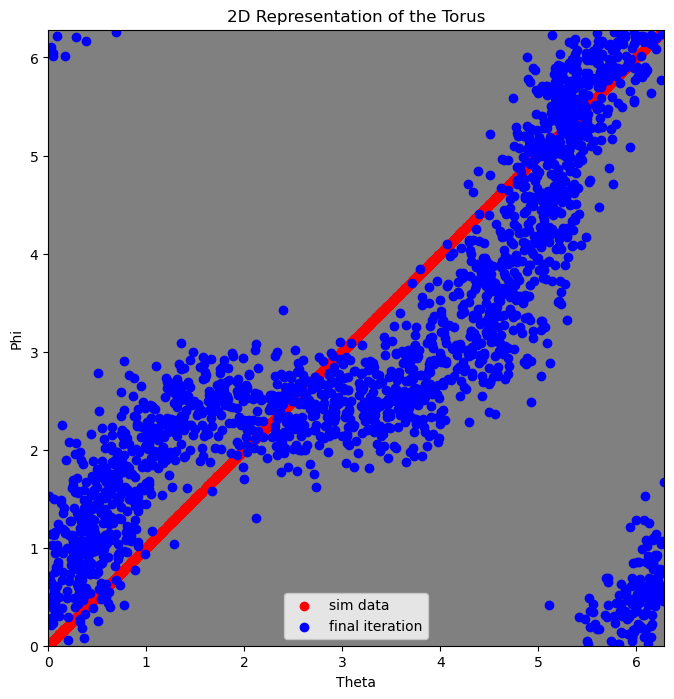

In [27]:

# Prepare the figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the torus grid (the 'unwraped' torus)
ax.imshow(np.ones(theta.shape), extent=[0, 2*np.pi, 0, 2*np.pi], cmap='gray', alpha=0.5)

# Plot the points (replace these with your specific points)
# Example points:

points_theta_sim = np.array(hd_sim)
points_phi_sim = np.array(hd_sim)

points_theta_res = np.array(estDir[:,0])
points_phi_res = np.array(estDir[:,1])

# Add the points to the plot
ax.scatter(points_theta_sim, points_phi_sim, color='red', label="sim data") # Original simulated data
ax.scatter(points_theta_res, points_phi_res, color='blue', label="final iteration") # after last interation

# Set labels and title
ax.set_xlabel('Theta')
ax.set_ylabel('Phi')
ax.set_title('2D Representation of the Torus')
ax.legend()

# Show the figure
plt.show()

In [53]:
# Function to calculate the log-likelihood for each time step in the test data
print(hd_sim_test.shape)
print(params.shape)
print(allspikes_test.shape)
def calculate_log_likelihoods(params, S, D):
    log_likelihoods = []
    for j in range(D.shape[0]):  # Iterating over time steps
        print(j)
        log_likelihood = logLtc(params[j], S[:,j], D)
        log_likelihoods.append(log_likelihood)
    return log_likelihoods

# As we do not have the actual direction data (D) for the test set, we will use the same approach as before
# Generating example directions data for the test data ('D')
example_D_test = np.random.rand(25, 2) * 2 * np.pi  # Example test directions data

# Calculating the log-likelihoods
log_likelihoods = calculate_log_likelihoods(params, allspikes_test, hd_sim_test)
log_likelihoods[:10]  # Displaying the first 10 log-likelihood values for a preview
sum_log_likelihood = sum(log_likelihoods)
print(sum_log_likelihood)

(500,)
(25, 5)
(25, 500)
0


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed